# High-level features

Apziva project #4: "MonReader"<br>
2023 07 29

__Summary:__
* In this workbook, two transfer learning models extracts __high-level image features (HLF)__ from the JPG files:
    * Inception
    * MobileNet
* The result is saved within the repository structure, as __Numpy arrays__.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Extracting HLF](#ExtractingHLF)
    * [Create file structure](#CreateFileStructure)
    * [Load transfer learning models](#LoadTransferLearningModels)
    * [Loop through image variants](#LoopThroughImageVariants)    

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrDownloadRoot =         "../../OutsideRepository/ImagesRaw/"
cstrImagePreparationRoot = "../../OutsideRepository/ImagesProcessed/"

cdintSquareSides =            {"Inception":299,"MobileNet":224}

clstrTransferLearningModels = ["Inception","MobileNet"]
clstrSquaringStrategies     = ["Squeeze","Crop"]

clstrDownloadDatasets =       ["training","testing"]
clstrDownloadClasses  =       ["flip","notflip"]

clstrMLModels =               ["L2","Random Forest","SVM"]

## Extracting HLF <a class="anchor" id="ExtractingHLF"></a>
[TOC](#TOC)

__Target file structure:__
* Repository
    * data
        * processed
            * __Inception__
                * __Crop__<br>X_train, y_train, X_test, y_test            
                * __Squeeze__<br>X_train, y_train, X_test, y_test
            * __MobileNet__
                * __Crop__<br>X_train, y_train, X_test, y_test            
                * __Squeeze__<br>X_train, y_train, X_test, y_test        

### Create file structure <a class="anchor" id="CreateFileStructure"></a>
[TOC](#TOC)

In [3]:
import pandas as pd
def CreateFolderStructureForImagesProcessed(strRoot):
    '''
    Creates a 4-level folder structure for processed images:
    - Transfer learning model
    - squaring strategy
    - dataset
    - target class
    
    When       Who What
    2023 07 27 dh  Created
    '''   

    # init
    lstrModels = []
    lstrStrategies = []
    lstrPaths = []
    
    # loop trough preprocessing variants
    for strTransferLearningModel in clstrTransferLearningModels:
        strModelPath = f"{strRoot}{strTransferLearningModel}/"
        os.makedirs(strModelPath)
        for strSquaringStrategy in clstrSquaringStrategies:
            strSquaringStrategyPath = f"{strModelPath}{strSquaringStrategy}/"
            os.makedirs(strSquaringStrategyPath)
            lstrModels.append(strTransferLearningModel)
            lstrStrategies.append(strSquaringStrategy)
            lstrPaths.append(strSquaringStrategyPath)
    
    # folders as dataframe
    dfrFolders = pd.DataFrame({"Models":lstrModels,"Strategies":lstrStrategies,"Folders":lstrPaths})
    
    # finalize
    p("The folder structure for the HLF features has been created successfully.")  
    p()
    return dfrFolders

if False:
    dfrFolders = CreateFolderStructureForImagesProcessed("../data/processed/")
    u.DisplayDataFrame(dfrFolders)

### Load transfer learning models <a class="anchor" id="LoadTransferLearningModels"></a>
[TOC](#TOC)

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

gcintChannels = 3
def SequentialModel (strModelName):
    '''
    Loads a transfer learning model.
    Current models available: Inception and MobileNet.
    2022 02 22 dh Created
    '''
    # source URL elements
    # Python 3 (for Python 2 see ADS-ML course project 4)
    cstrUrlPart1 = "https://tfhub.dev/google/imagenet/"
    cstrUrlPart3 = "/feature_vector/5"
    
    # define model parameters
    strModelNameLower = strModelName.lower()
    if strModelNameLower == "inception":
        intSquareSide = 299
        strUrlPart2 = "inception_v3"
    elif strModelNameLower == "mobilenet":
        intSquareSide = 224
        strUrlPart2 = "mobilenet_v2_100_224"
    else:
        p(f"WARNING: The model {strModelName} does not exist. Possible models: Inception and Mobilenet.")
        return
    
    # try to load the model
    strModelUrl = cstrUrlPart1 + strUrlPart2 + cstrUrlPart3
    try:
        objSequentialModel = tf.keras.Sequential([hub.KerasLayer(strModelUrl, trainable=False)])  # can be True, see below.     
    except:
        p("The sequential model cannot be loaded.")
        p(r"Maybe the folder 'C:\Users\domin\AppData\Local\Temp\tfhub_modules' has to be deleted.")
        p(r"At least this was the case in ADS-ML course project 4, under certain conditions.")  
        return
    
    # build model
    lintBatchInputShape = [None, intSquareSide, intSquareSide, gcintChannels]
    objSequentialModel.build(lintBatchInputShape)
    p(f"The sequential model '{strModelName}' has been loaded successfully.")
    return objSequentialModel

def LoadAllTransferLearningModels():
    '''
    Loads all transfer learning models from a list.
    Current models foreseen: Inception and MobileNet.
    
    2023 07 29 dh Created
    '''    
    # load models
    p("Loading the transfer learning models will take about 5 seconds...")
    u.StopWatch()
    dobjSequentialModels = {}
    for strTransferLearningModel in clstrTransferLearningModels:
        dobjSequentialModels[strTransferLearningModel] = SequentialModel(strTransferLearningModel)   
    p("Time used to load:")
    u.StopWatch("seconds",1)    
    
    # finalize
    return dobjSequentialModels

### Loop through image variants <a class="anchor" id="LoopThroughImageVariants"></a>
[TOC](#TOC)

In [5]:
from tensorflow.keras.preprocessing import image
def ImageAs4DArray(strImagePath):
    '''
    Gets image from a file and converts into a Numpy array, ready to be used by the transfer learning model.
    
    2023 07 29 dh Created
    '''      
    
    # get image from disk, as a PIL image
    pilImage = image.load_img(strImagePath)
    
    # convert it into a 3D array
    a3intPixels = image.img_to_array(pilImage) # dimensions: pixels, pixels, color channel
    
    # add a dimension for batch
    a4intPixels = np.expand_dims(a3intPixels, axis=0) # dimensions: batch, pixels, pixels, channel
    
    # finalize
    return a4intPixels

In [6]:
import numpy as np
def ExtractHLF(dfrFolders,dobjSequentialModels):
    '''
    Extracts high-level images features:
        - gets processed JPG files
        - applies transfer learning model
        - saves as Numpy array
    
    2023 07 29 dh Created
    '''
    
    # init
    dlfltTimeUsed = {"Inception":[],"MobileNet":[]}
    p()
    p("Extracting high-level image features (HLF)".upper())
    p()
    
    for intIndex, srsRecord in dfrFolders.iterrows():
        
        # define target folder
        strModel = srsRecord['Models']
        strStrategy = srsRecord['Strategies']
        strTargetFolder = srsRecord['Folders']
        
        # select model
        objSequentialModel = dobjSequentialModels[strModel]

        for strDataset in clstrDownloadDatasets:
            
            for strClass in clstrDownloadClasses:

                # get names of source files
                strImageFolder = f"../../OutsideRepository/ImagesProcessed/{strModel}/{strStrategy}/{strDataset}/{strClass}/"
                lstrImageFiles = [os.path.join(strImageFolder, strFilename) for strFilename in os.listdir(strImageFolder) if os.path.isfile(os.path.join(strImageFolder, strFilename))]

                # init list for HLF
                lafltAllHighLevelFeatures = []

                # create HLF
                for strFilename in lstrImageFiles:
                    a4intPixels = ImageAs4DArray(strFilename)
                    u.StopWatch()
                    a2fltHighLevelFeatures = objSequentialModel.predict(a4intPixels)
                    dlfltTimeUsed[strModel].append(u.StopWatch("seconds",blnAsFloat=True))
                    a1fltHighLevelFeatures = a2fltHighLevelFeatures.flatten()
                    lafltAllHighLevelFeatures.append(a1fltHighLevelFeatures)

                # convert the list of features to a numpy array
                X = np.array(lafltAllHighLevelFeatures)
                intRecords = len(X)
                y = np.ones(intRecords) if strClass == "flip" else np.zeros(intRecords)
                
                # combine "flip" and "notflip"
                if strClass == "flip":
                    X_both_classes = X
                    y_both_classes = y
                else:
                    X_both_classes = np.vstack((X_both_classes, X))
                    y_both_classes = np.hstack((y_both_classes, y))

            p(f"{strModel}/{strStrategy}/{strDataset}")
            if False:
                u.DisplayDataFrame(pd.DataFrame( X_both_classes))
                u.DisplayDataFrame(pd.DataFrame( y_both_classes))

            # save
            strDatasetShort = "train" if strDataset in ["train","training"] else "test"
            u.ToDisk(X_both_classes,f"{strTargetFolder}X_{strDatasetShort}")
            u.ToDisk(y_both_classes,f"{strTargetFolder}y_{strDatasetShort}")

            p("- ",f"{strTargetFolder}X_{strDatasetShort}")
            p("- ",f"{strTargetFolder}y_{strDatasetShort}")

    # statistics
    p()
    p("Seconds used to get HLF:".upper())
    dfrTimesUsed = pd.DataFrame(dlfltTimeUsed)
    u.DisplayDataFrame(dfrTimesUsed.describe().applymap(lambda x: round(x, 3)).T)
    ml.DrawDistributionPlots(
        dfrTimesUsed, ["Inception","MobileNet"],
        intDiagramColumns=2,intBins=50,
        fltTotalWidth=10,fltTotalHeight=3.5
    )

The folder structure for the HLF features has been created successfully.

Loading the transfer learning models will take about 5 seconds...
The sequential model 'Inception' has been loaded successfully.
The sequential model 'MobileNet' has been loaded successfully.
Time used to load:
6.0 seconds

EXTRACTING HIGH-LEVEL IMAGE FEATURES (HLF)

Inception/Squeeze/training
-  ../data/processed/Inception/Squeeze/X_train
-  ../data/processed/Inception/Squeeze/y_train
Inception/Squeeze/testing
-  ../data/processed/Inception/Squeeze/X_test
-  ../data/processed/Inception/Squeeze/y_test
Inception/Crop/training
-  ../data/processed/Inception/Crop/X_train
-  ../data/processed/Inception/Crop/y_train
Inception/Crop/testing
-  ../data/processed/Inception/Crop/X_test
-  ../data/processed/Inception/Crop/y_test
MobileNet/Squeeze/training
-  ../data/processed/MobileNet/Squeeze/X_train
-  ../data/processed/MobileNet/Squeeze/y_train
MobileNet/Squeeze/testing
-  ../data/processed/MobileNet/Squeeze/X_test
-  ..

,count,mean,std,min,25%,50%,75%,max
Inception,5978.0,0.096,0.014,0.088,0.092,0.093,0.096,0.707
MobileNet,5978.0,0.053,0.010,0.048,0.050,0.051,0.053,0.404


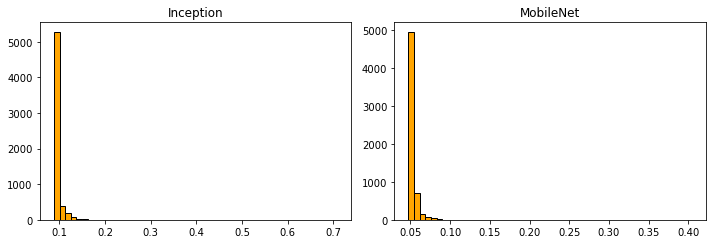

In [7]:
import os

# init
cstrRootPath = "../data/processed/"
strInceptionPath = f"{cstrRootPath}Inception/"

# check if to be done
if os.path.exists(strInceptionPath):
    
    # don't re-extract HLF
    strAbsolutePath = os.path.abspath(strInceptionPath)
    p("Folder exists".upper())
    p("- The HLF are not extracted to Numpy arrays: this has been done before.")
    p("- If HLF shall be extracted again, the following folder has to be deleted:")
    p(f"     {strAbsolutePath}")
    p("- Extracting the HLF again may take a xxx minutes.")
    
else:
    
    # extract HLF
    dfrFolders = CreateFolderStructureForImagesProcessed(cstrRootPath)
    dobjSequentialModels = LoadAllTransferLearningModels()
    ExtractHLF(dfrFolders,dobjSequentialModels)

__Observations:__
* Typical times are __below 120 ms__.
* Both models show __outliers__, around  half a second.
* In general, __MobileNet is faster__:
    * MobileNet times are __below 70 ms__ most of the time.
    * This may be due 
        * to the smaller image input square to be processed, 
        * and only 1280 features are created (Inception: 2048).
    * Maybe this is connected to worse classification power later on.